**Import the required packages**

In [ ]:
!pip install feature-engine
!pip install lime
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.0/375.0 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=775dd6941ddecd35b7a03ede3b6bd20f2a986a9f0a3f133909b535a596a30316
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import pandas as pd
from scipy import stats
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from feature_engine.outliers import ArbitraryOutlierCapper
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn import tree
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import os

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

from lime.lime_tabular import LimeTabularExplainer

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_excel('/content/drive/MyDrive/Colab Notebooks/FYP/LungCancerRiskFactorStatistics.xlsx')

In [ ]:
df.head()

,Age,Gender,Air Pollution,Alcohol Usage,Genetic Risk,Lung Disease,Obesity,Smoking,Severity
0,37,Female,High Exposure,High Usage,Elevated Risk,Severe Symptoms,Class 3 Obesity,Moderate-High Smoking,High
1,37,Male,High Exposure,High Usage,Elevated Risk,Severe Symptoms,Class 3 Obesity,Moderate-High Smoking,High
2,37,Female,High Exposure,High Usage,Elevated Risk,Severe Symptoms,Class 3 Obesity,Moderate-High Smoking,High
3,37,Male,High Exposure,High Usage,Elevated Risk,Severe Symptoms,Class 3 Obesity,Moderate-High Smoking,High
4,37,Female,High Exposure,High Usage,Elevated Risk,Severe Symptoms,Class 3 Obesity,Moderate-High Smoking,High


# **Data Preprocessing**
---

In [ ]:
# Check for missing values
df.isnull().sum().sort_values(ascending=False)

,0
Genetic Risk,33
Alcohol Usage,21
Gender,15
Lung Disease,15
Obesity,14
Air Pollution,11
Smoking,7
Age,0
Severity,0


In [ ]:
categorical_columns = ['Gender', 'Air Pollution', 'Alcohol Usage', 'Genetic Risk', 'Lung Disease', 'Obesity', 'Smoking']

# Filling missing values with the mode
for col in categorical_columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Re-check for missing values
missing_values_after = df.isnull().sum()
missing_values_after

<ipython-input-7-9a5f68dbfdb5>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


,0
Age,0
Gender,0
Air Pollution,0
Alcohol Usage,0
Genetic Risk,0
Lung Disease,0
Obesity,0
Smoking,0
Severity,0


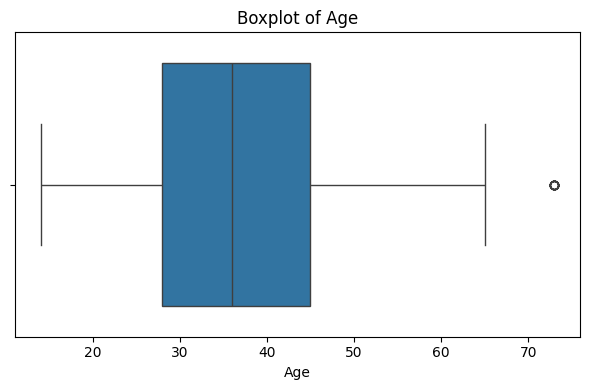

In [ ]:
plt.figure(figsize=(6, 4))
sns.boxplot(x=df['Age'])
plt.title('Boxplot of Age')
plt.tight_layout()
plt.show()

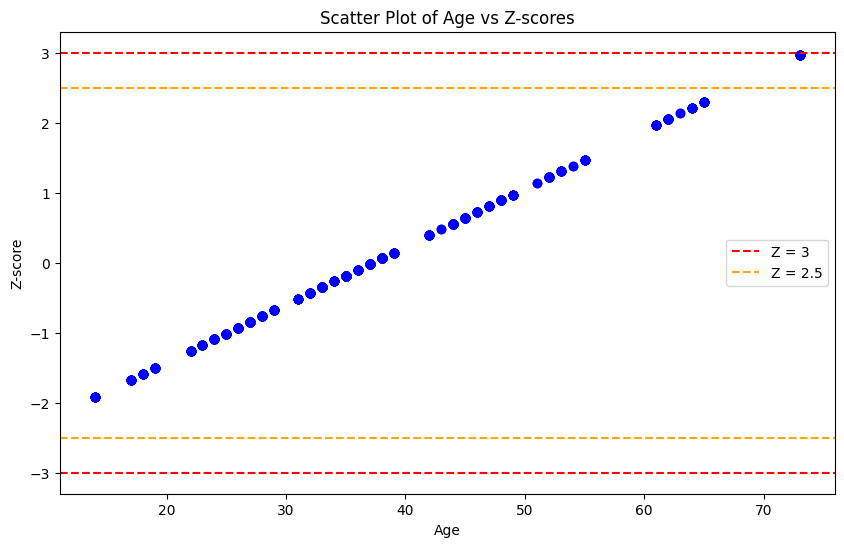

In [ ]:
# Calculate the Z-scores for the 'Age' column
z_scores = stats.zscore(df['Age'])

plt.figure(figsize=(10, 6))
plt.scatter(df['Age'], z_scores, color='blue')
plt.axhline(y=3, color='r', linestyle='--', label='Z = 3')
plt.axhline(y=-3, color='r', linestyle='--')
plt.axhline(y=2.5, color='orange', linestyle='--', label='Z = 2.5')
plt.axhline(y=-2.5, color='orange', linestyle='--')
plt.title('Scatter Plot of Age vs Z-scores')
plt.xlabel('Age')
plt.ylabel('Z-score')
plt.legend()
plt.show()

In [ ]:
data = df.copy()
severity_distribution = data['Severity'].value_counts(normalize=True)
severity_distribution

,proportion
Severity,
Healthy,0.317406
High,0.249147
Medium,0.226621
Low,0.206826


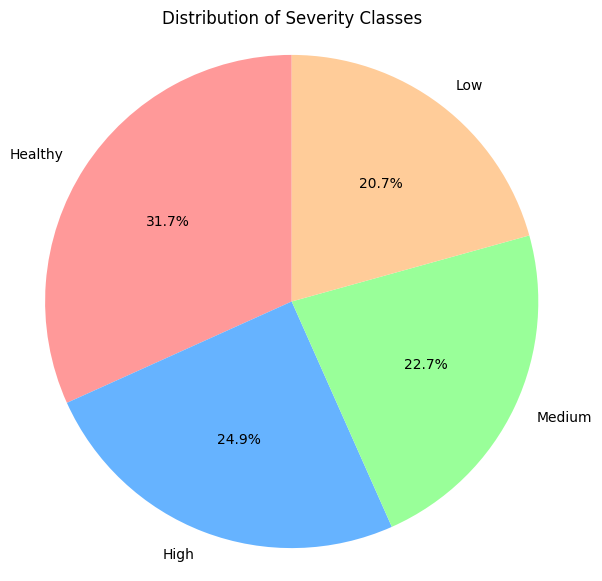

In [ ]:
# Creating a pie chart for the 'Severity' class distribution
plt.figure(figsize=(7, 7))
plt.pie(severity_distribution, labels=severity_distribution.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title('Distribution of Severity Classes')
plt.axis('equal')
plt.show()

In [ ]:
# Define ordinal mappings for each variable
ordinal_mappings = {
    "Air Pollution": {
        "Minimal Exposure": 0,
        "Very Low Exposure": 1,
        "Low Exposure": 2,
        "Moderate-Low Exposure": 3,
        "Moderate Exposure": 4,
        "Moderate-High Exposure": 5,
        "High Exposure": 6,
        "Extreme Exposure": 7,
    },
    "Alcohol Usage": {
        "Not Used": 0,
        "Very Low Usage": 1,
        "Low Usage": 2,
        "Moderate-Low Usage": 3,
        "Moderate Usage": 4,
        "Moderate-High Usage": 5,
        "High Usage": 6,
        "Excessive Usage": 7,
    },
    "Genetic Risk": {
        "No Risk": 0,
        "Minimal Risk": 1,
        "Very Low Risk": 2,
        "Low Risk": 3,
        "Moderate Risk": 4,
        "High Risk": 5,
        "Elevated Risk": 6,
    },
    "Lung Disease": {
        "Healthy Lungs": 0,
        "Occasional Mild Cough": 1,
        "Seasonal Allergies,Mild Asthma": 2,
        "Moderate Asthma": 3,
        "Moderate to Significant Symptoms": 4,
        "Significant Symptoms": 5,
        "Severe Symptoms": 6,
    },
    "Obesity": {
        "Normal Weight": 0,
        "Slightly Over Weight": 1,
        "At Risk of Obesity": 2,
        "Pre-Obesity": 3,
        "Class 1 Obesity": 4,
        "Class 2 Obesity": 5,
        "Class 3 Obesity": 6,
    },
    "Smoking": {
        "Non-Smoker": 0,
        "Passive Smoker": 1,
        "Minimal Smoking": 2,
        "Very Low Smoking": 3,
        "Low Smoking": 4,
        "Moderate-Low Smoking": 5,
        "Moderate Smoking": 6,
        "Moderate-High Smoking": 7,
        "High Smoking": 8,
    },
    "Severity": {
        "Healthy": 0,
        "Low": 1,
        "Medium": 2,
        "High": 3,
    },
}

for column, mapping in ordinal_mappings.items():
    data[column] = data[column].map(mapping)

# Encode Gender as binary
data["Gender"] = df["Gender"].map({"Female": 0, "Male": 1})

data.head()

,Age,Gender,Air Pollution,Alcohol Usage,Genetic Risk,Lung Disease,Obesity,Smoking,Severity
0,37,0,6,6,6,6,6,7,3
1,37,1,6,6,6,6,6,7,3
2,37,0,6,6,6,6,6,7,3
3,37,1,6,6,6,6,6,7,3
4,37,0,6,6,6,6,6,7,3


# **EDA**
---

In [ ]:
df.head()

,Age,Gender,Air Pollution,Alcohol Usage,Genetic Risk,Lung Disease,Obesity,Smoking,Severity
0,37,Female,High Exposure,High Usage,Elevated Risk,Severe Symptoms,Class 3 Obesity,Moderate-High Smoking,High
1,37,Male,High Exposure,High Usage,Elevated Risk,Severe Symptoms,Class 3 Obesity,Moderate-High Smoking,High
2,37,Female,High Exposure,High Usage,Elevated Risk,Severe Symptoms,Class 3 Obesity,Moderate-High Smoking,High
3,37,Male,High Exposure,High Usage,Elevated Risk,Severe Symptoms,Class 3 Obesity,Moderate-High Smoking,High
4,37,Female,High Exposure,High Usage,Elevated Risk,Severe Symptoms,Class 3 Obesity,Moderate-High Smoking,High


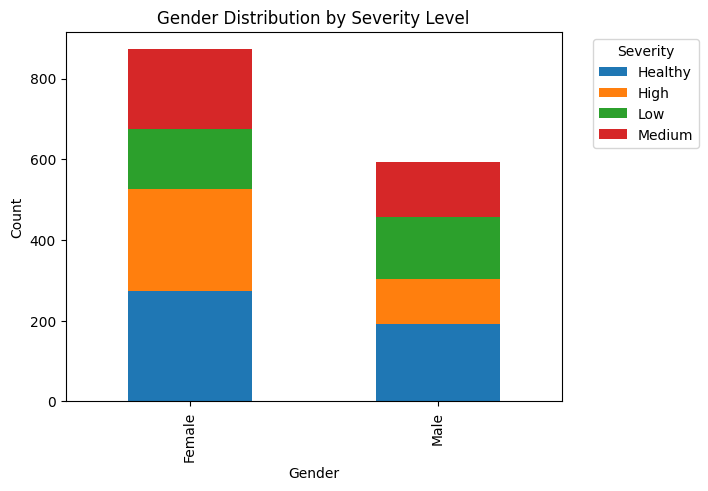

In [ ]:
# Gender Distribution by Severity Level

import matplotlib.pyplot as plt

Gender_Severity = df.groupby(['Gender', 'Severity']).size().unstack()
Gender_Severity.plot(kind='bar', stacked=True)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution by Severity Level')
_ = plt.legend(title='Severity', bbox_to_anchor=(1.05, 1), loc='upper left')

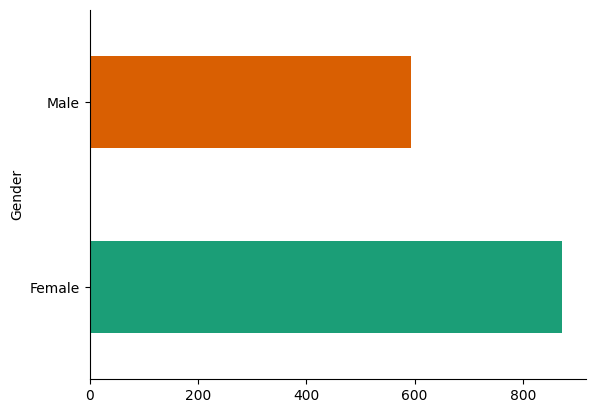

In [ ]:
# Gender

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

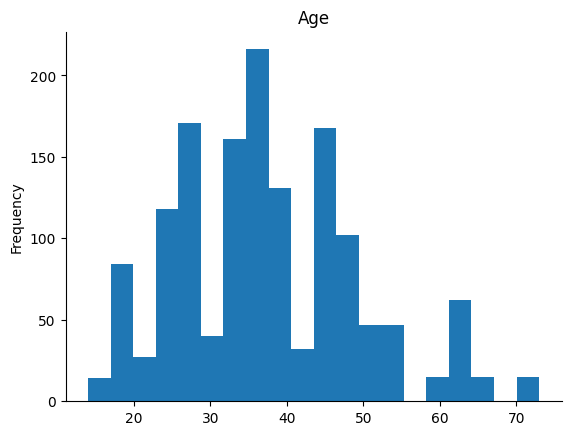

In [ ]:
# Age

from matplotlib import pyplot as plt
df['Age'].plot(kind='hist', bins=20, title='Age')
plt.gca().spines[['top', 'right',]].set_visible(False)

<ipython-input-17-95860ca9a878>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Age', y='Severity', inner='box', palette='Dark2', order=severity_order)


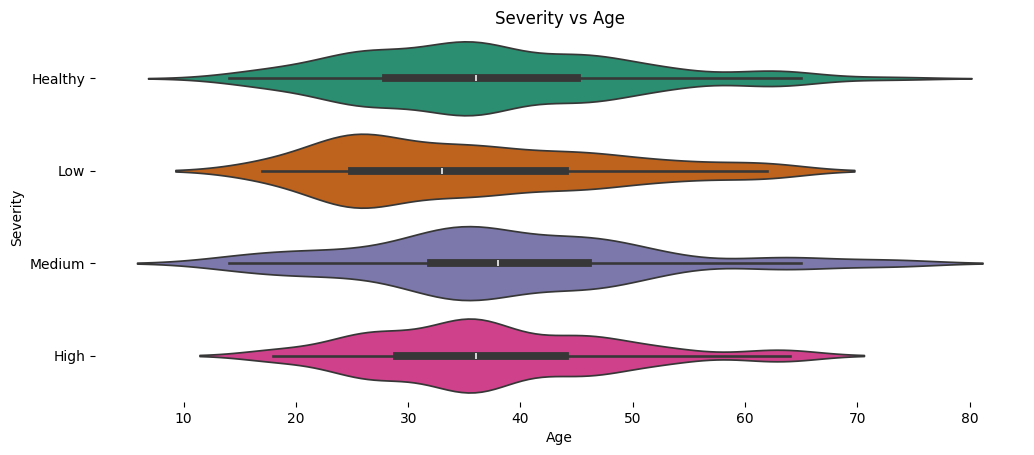

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

severity_order = ['Healthy', 'Low', 'Medium', 'High']

df['Severity'] = pd.Categorical(df['Severity'], categories=severity_order, ordered=True)

figsize = (12, 1.2 * len(df['Severity'].unique()))

plt.figure(figsize=figsize)
sns.violinplot(data=df, x='Age', y='Severity', inner='box', palette='Dark2', order=severity_order)

sns.despine(top=True, right=True, bottom=True, left=True)

plt.title('Severity vs Age')
plt.show()

<ipython-input-18-0f33570241d8>:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_severity = df.groupby([category, 'Severity']).size().unstack()


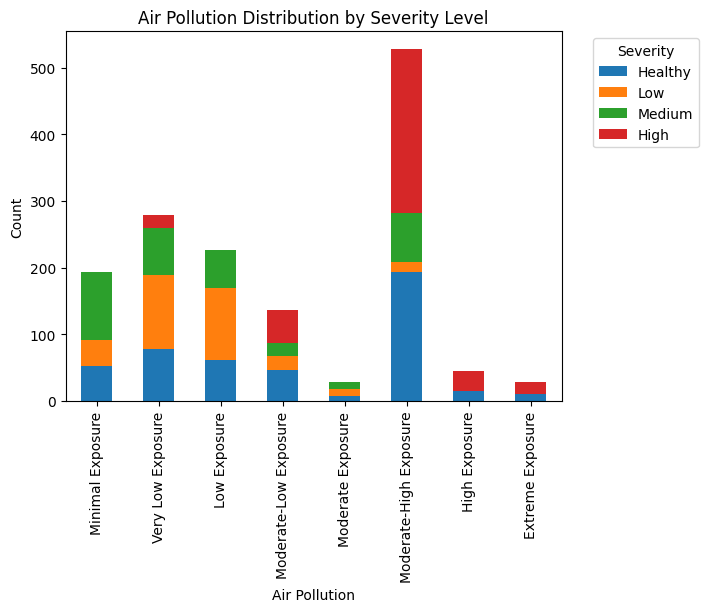

<ipython-input-18-0f33570241d8>:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_severity = df.groupby([category, 'Severity']).size().unstack()


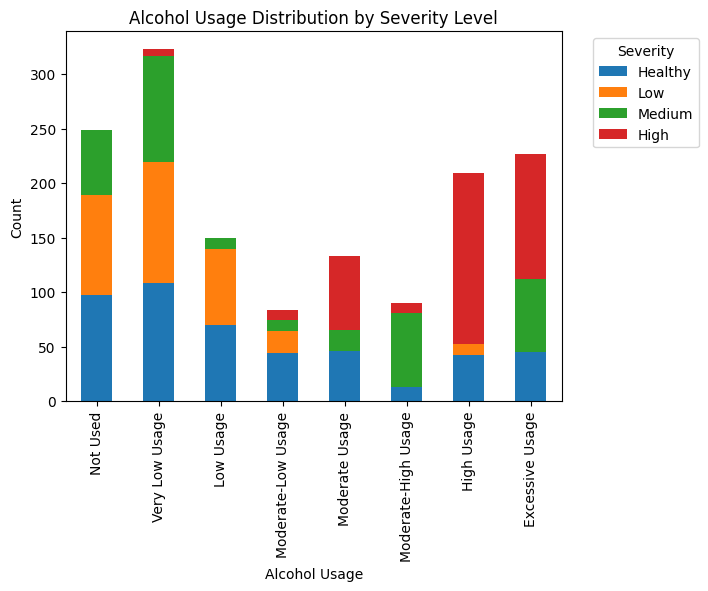

<ipython-input-18-0f33570241d8>:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_severity = df.groupby([category, 'Severity']).size().unstack()


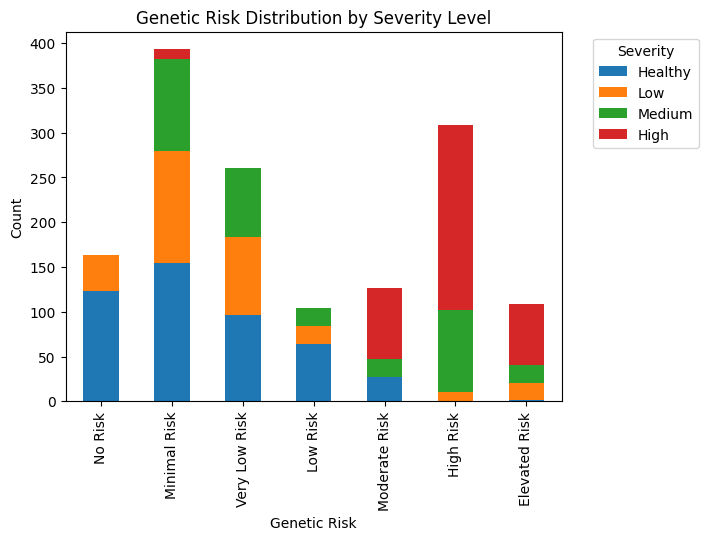

<ipython-input-18-0f33570241d8>:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_severity = df.groupby([category, 'Severity']).size().unstack()


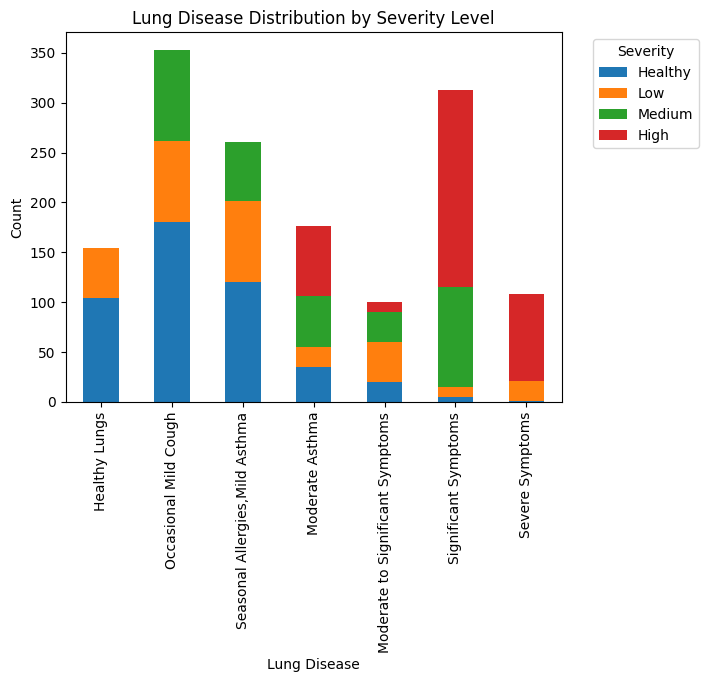

<ipython-input-18-0f33570241d8>:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_severity = df.groupby([category, 'Severity']).size().unstack()


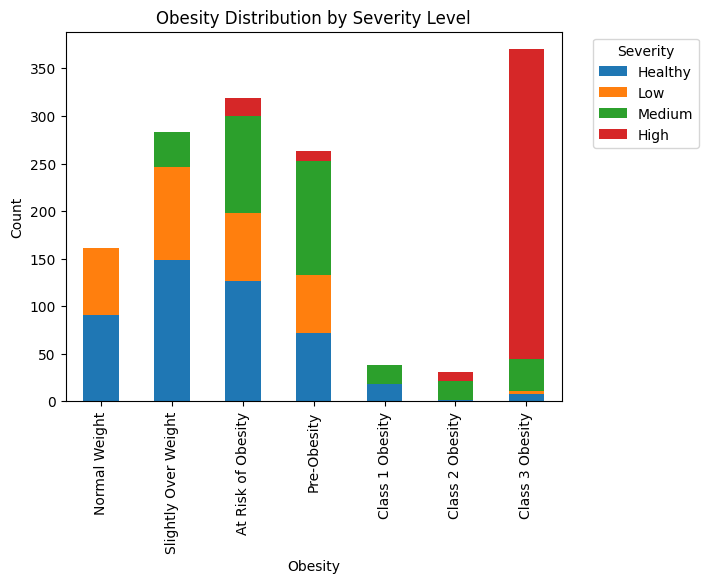

<ipython-input-18-0f33570241d8>:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_severity = df.groupby([category, 'Severity']).size().unstack()


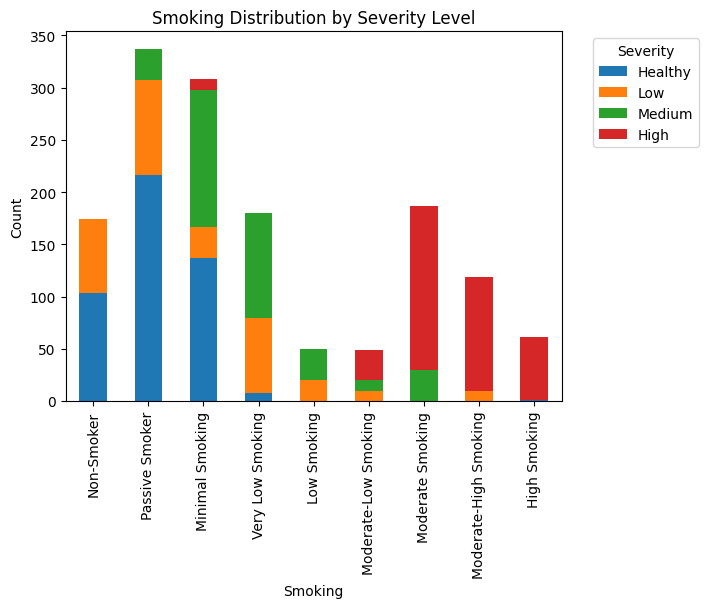

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Air Pollution order
air_pollution_order = ['Minimal Exposure', 'Very Low Exposure', 'Low Exposure',
                       'Moderate-Low Exposure', 'Moderate Exposure',
                       'Moderate-High Exposure', 'High Exposure', 'Extreme Exposure']

# Alcohol Usage order
alcohol_usage_order = ['Not Used', 'Very Low Usage', 'Low Usage',
                       'Moderate-Low Usage', 'Moderate Usage',
                       'Moderate-High Usage', 'High Usage', 'Excessive Usage']

# Genetic Risk order
genetic_risk_order = ['No Risk', 'Minimal Risk', 'Very Low Risk', 'Low Risk',
                      'Moderate Risk', 'High Risk', 'Elevated Risk']

# Lung Disease order
lung_disease_order = ['Healthy Lungs', 'Occasional Mild Cough', 'Seasonal Allergies,Mild Asthma',
                      'Moderate Asthma', 'Moderate to Significant Symptoms',
                      'Significant Symptoms', 'Severe Symptoms']

# Obesity order
obesity_order = ['Normal Weight', 'Slightly Over Weight', 'At Risk of Obesity', 'Pre-Obesity',
                 'Class 1 Obesity', 'Class 2 Obesity', 'Class 3 Obesity']

# Smoking order
smoking_order = ['Non-Smoker', 'Passive Smoker', 'Minimal Smoking', 'Very Low Smoking',
                 'Low Smoking', 'Moderate-Low Smoking', 'Moderate Smoking',
                 'Moderate-High Smoking', 'High Smoking']

df['Air Pollution'] = pd.Categorical(df['Air Pollution'], categories=air_pollution_order, ordered=True)
df['Alcohol Usage'] = pd.Categorical(df['Alcohol Usage'], categories=alcohol_usage_order, ordered=True)
df['Genetic Risk'] = pd.Categorical(df['Genetic Risk'], categories=genetic_risk_order, ordered=True)
df['Lung Disease'] = pd.Categorical(df['Lung Disease'], categories=lung_disease_order, ordered=True)
df['Obesity'] = pd.Categorical(df['Obesity'], categories=obesity_order, ordered=True)
df['Smoking'] = pd.Categorical(df['Smoking'], categories=smoking_order, ordered=True)

def plot_category_distribution(df, category, title):
    category_severity = df.groupby([category, 'Severity']).size().unstack()
    category_severity.plot(kind='bar', stacked=True)
    plt.xlabel(category)
    plt.ylabel('Count')
    plt.title(title)
    plt.legend(title='Severity', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

plot_category_distribution(df, 'Air Pollution', 'Air Pollution Distribution by Severity Level')
plot_category_distribution(df, 'Alcohol Usage', 'Alcohol Usage Distribution by Severity Level')
plot_category_distribution(df, 'Genetic Risk', 'Genetic Risk Distribution by Severity Level')
plot_category_distribution(df, 'Lung Disease', 'Lung Disease Distribution by Severity Level')
plot_category_distribution(df, 'Obesity', 'Obesity Distribution by Severity Level')
plot_category_distribution(df, 'Smoking', 'Smoking Distribution by Severity Level')

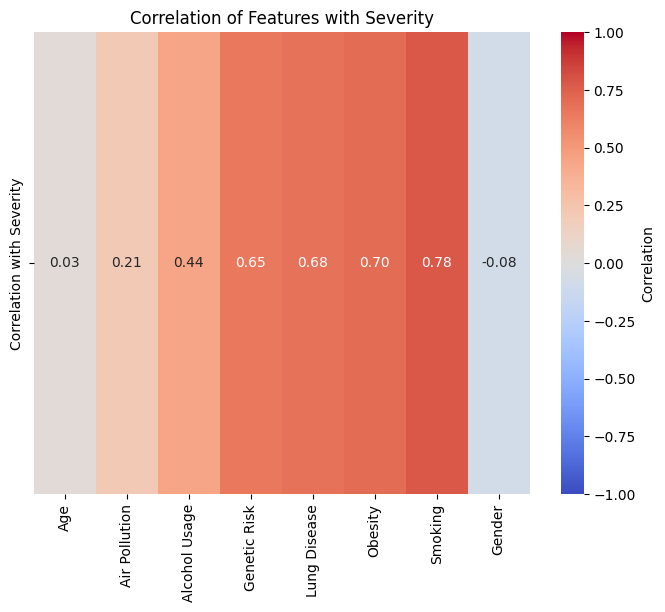

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pointbiserialr

# List of ordinal features to check correlation with Severity (target)
ordinal_features = [
    "Age",  # Including Age as a numerical feature
    "Air Pollution",
    "Alcohol Usage",
    "Genetic Risk",
    "Lung Disease",
    "Obesity",
    "Smoking"
]

correlation_matrix = {}

# Step 1: Calculate Spearman's Rank Correlation for Ordinal Features vs Severity (Target)
for feature in ordinal_features:
    spearman_corr, _ = spearmanr(data[feature], data['Severity'])
    correlation_matrix[feature] = spearman_corr

# Step 2: Calculate Point-Biserial Correlation between Gender and Severity (Target)
pointbiserial_corr_gender_severity, _ = pointbiserialr(data['Gender'], data['Severity'])
correlation_matrix['Gender'] = pointbiserial_corr_gender_severity

# Convert the correlation dictionary into a DataFrame for easy plotting
correlation_df = pd.DataFrame.from_dict(correlation_matrix, orient='index', columns=['Correlation with Severity'])

# Step 3: Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_df.T, annot=True, cmap="coolwarm", vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'}, fmt='.2f')
plt.title('Correlation of Features with Severity')
plt.show()

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

scaler = StandardScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(data.drop(columns=['Severity'])),
                         columns=data.columns[:-1])

vif_data = pd.DataFrame()
vif_data["Feature"] = df_scaled.columns

vif_data["VIF"] = [variance_inflation_factor(df_scaled.values, i) for i in range(df_scaled.shape[1])]

print(vif_data)

         Feature       VIF
0            Age  1.039277
1         Gender  1.050989
2  Air Pollution  1.365770
3  Alcohol Usage  2.064046
4   Genetic Risk  2.860226
5   Lung Disease  2.645688
6        Obesity  2.824927
7        Smoking  3.112171


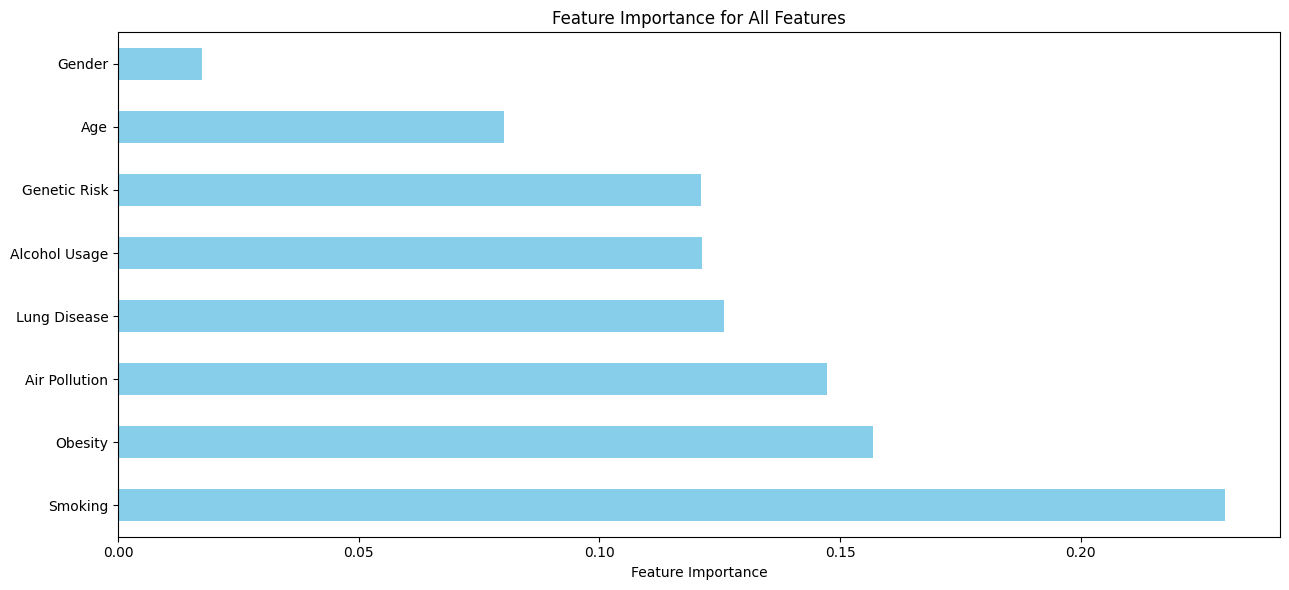

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd

X = data.drop(columns=['Severity'])
y = data['Severity']

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns)
sorted_features = feature_importance.sort_values(ascending=False)

plt.figure(figsize=(13, 6))
sorted_features.plot(kind='barh', color='skyblue')
plt.title('Feature Importance for All Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

In [ ]:
del data['Gender']

# **Model Development**
---

In [ ]:
X = data.drop(columns=['Severity'])
y = data['Severity']

In [ ]:
# Splitting the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1172, 7)
(293, 7)
(1172,)
(293,)


In [ ]:
'''
#standardization
scaler = StandardScaler()

data['Age'] = scaler.fit_transform(data[['Age']])

'''

"\n#standardization\nscaler = StandardScaler()\n\ndata['Age'] = scaler.fit_transform(data[['Age']])\n\n"

In [ ]:
preprocessed_dataset_path = '/content/drive/MyDrive/Colab Notebooks/FYP/preprocessed_dataset.csv'
data.to_csv(preprocessed_dataset_path, index=False)

In [ ]:
save_dir = '/content/drive/MyDrive/Colab Notebooks/FYP/Models/'

os.makedirs(save_dir, exist_ok=True)

# List of models to train
models = {
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

metrics = {}

for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)

    metrics[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Confusion Matrix': conf_matrix
    }

    filename = f'{save_dir}{model_name}_model.pkl'
    joblib.dump(model, filename)

for model_name, metric in metrics.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {metric['Accuracy']:.4f}")
    print(f"Precision: {metric['Precision']:.4f}")
    print(f"Recall: {metric['Recall']:.4f}")
    print(f"F1-Score: {metric['F1-Score']:.4f}")
    print(f"Confusion Matrix:\n{metric['Confusion Matrix']}")
    print("\n" + "-"*50 + "\n")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:37:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model: SVM
Accuracy: 0.6962
Precision: 0.6861
Recall: 0.6962
F1-Score: 0.6810
Confusion Matrix:
[[81  8  2  0]
 [30 38  8  0]
 [10 21 20  5]
 [ 0  0  5 65]]

--------------------------------------------------

Model: KNN
Accuracy: 0.9181
Precision: 0.9225
Recall: 0.9181
F1-Score: 0.9173
Confusion Matrix:
[[73  8 10  0]
 [ 2 73  1  0]
 [ 2  1 53  0]
 [ 0  0  0 70]]

--------------------------------------------------

Model: Random Forest
Accuracy: 0.9932
Precision: 0.9932
Recall: 0.9932
F1-Score: 0.9932
Confusion Matrix:
[[90  1  0  0]
 [ 1 75  0  0]
 [ 0  0 56  0]
 [ 0  0  0 70]]

--------------------------------------------------

Model: Naive Bayes
Accuracy: 0.6485
Precision: 0.6446
Recall: 0.6485
F1-Score: 0.6446
Confusion Matrix:
[[73 12  6  0]
 [26 36 14  0]
 [ 7 23 21  5]
 [ 0  0 10 60]]

--------------------------------------------------

Model: XGBoost
Accuracy: 0.9761
Precision: 0.9763
Recall: 0.9761
F1-Score: 0.9761
Confusion Matrix:
[[87  2  2  0]
 [ 1 74  1  0]
 [ 1  0 55  

In [ ]:
save_dir = '/content/drive/MyDrive/Colab Notebooks/FYP/Models/'
os.makedirs(save_dir, exist_ok=True)

# List of models to tune
models = {
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Define hyperparameter grids
param_grids = {
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree']
    },
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 6, 9]
    }
}

metrics = {}

for model_name, model in models.items():
    print(f"Tuning {model_name}...")

    # Grid search for hyperparameter tuning
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    # Make predictions on the test set
    y_pred = best_model.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Store the metrics for each model
    metrics[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Confusion Matrix': conf_matrix
    }

    filename = f'{save_dir}{model_name}_tuned_model_GridSearch.pkl'
    joblib.dump(best_model, filename)

for model_name, metric in metrics.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {metric['Accuracy']:.4f}")
    print(f"Precision: {metric['Precision']:.4f}")
    print(f"Recall: {metric['Recall']:.4f}")
    print(f"F1-Score: {metric['F1-Score']:.4f}")
    print(f"Confusion Matrix:\n{metric['Confusion Matrix']}")
    print("\n" + "-"*50 + "\n")

Tuning SVM...
Tuning KNN...
Tuning Random Forest...
Tuning XGBoost...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:39:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model: SVM
Accuracy: 0.9522
Precision: 0.9528
Recall: 0.9522
F1-Score: 0.9524
Confusion Matrix:
[[85  4  2  0]
 [ 2 73  1  0]
 [ 1  1 54  0]
 [ 3  0  0 67]]

--------------------------------------------------

Model: KNN
Accuracy: 0.9352
Precision: 0.9360
Recall: 0.9352
F1-Score: 0.9351
Confusion Matrix:
[[80  4  7  0]
 [ 3 72  1  0]
 [ 3  1 52  0]
 [ 0  0  0 70]]

--------------------------------------------------

Model: Random Forest
Accuracy: 0.9932
Precision: 0.9932
Recall: 0.9932
F1-Score: 0.9932
Confusion Matrix:
[[90  1  0  0]
 [ 1 75  0  0]
 [ 0  0 56  0]
 [ 0  0  0 70]]

--------------------------------------------------

Model: XGBoost
Accuracy: 0.9829
Precision: 0.9831
Recall: 0.9829
F1-Score: 0.9829
Confusion Matrix:
[[89  1  1  0]
 [ 2 73  1  0]
 [ 0  0 56  0]
 [ 0  0  0 70]]

--------------------------------------------------



In [ ]:
save_dir = '/content/drive/MyDrive/Colab Notebooks/FYP/Models/'
os.makedirs(save_dir, exist_ok=True)

models = {
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42)
}

param_grids = {
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree']
    },
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    }
}

metrics = {}

for model_name, model in models.items():
    print(f"Tuning {model_name}...")

    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grids[model_name], cv=5,
                                       scoring='accuracy', n_jobs=-1, n_iter=10, random_state=42)
    random_search.fit(X_train, y_train)

    best_model = random_search.best_estimator_

    y_pred = best_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)

    metrics[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Confusion Matrix': conf_matrix
    }

    filename = f'{save_dir}{model_name}_tuned_model_RandomSearch.pkl'
    joblib.dump(best_model, filename)

for model_name, metric in metrics.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {metric['Accuracy']:.4f}")
    print(f"Precision: {metric['Precision']:.4f}")
    print(f"Recall: {metric['Recall']:.4f}")
    print(f"F1-Score: {metric['F1-Score']:.4f}")
    print(f"Confusion Matrix:\n{metric['Confusion Matrix']}")
    print("\n" + "-"*50 + "\n")  # Line separator between models

Tuning SVM...
Tuning KNN...
Tuning Random Forest...
Model: SVM
Accuracy: 0.9522
Precision: 0.9528
Recall: 0.9522
F1-Score: 0.9524
Confusion Matrix:
[[85  4  2  0]
 [ 2 73  1  0]
 [ 1  1 54  0]
 [ 3  0  0 67]]

--------------------------------------------------

Model: KNN
Accuracy: 0.9352
Precision: 0.9360
Recall: 0.9352
F1-Score: 0.9351
Confusion Matrix:
[[80  4  7  0]
 [ 3 72  1  0]
 [ 3  1 52  0]
 [ 0  0  0 70]]

--------------------------------------------------

Model: Random Forest
Accuracy: 0.9932
Precision: 0.9932
Recall: 0.9932
F1-Score: 0.9932
Confusion Matrix:
[[90  1  0  0]
 [ 1 75  0  0]
 [ 0  0 56  0]
 [ 0  0  0 70]]

--------------------------------------------------



In [ ]:
save_dir = '/content/drive/MyDrive/Colab Notebooks/FYP/Models/'
os.makedirs(save_dir, exist_ok=True)

# 5-Fold Stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'SVM': SVC(probability=True, random_state=42, C=1, kernel='rbf', gamma='scale'),
    'KNN': KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto'),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=200, max_depth=20, min_samples_split=5),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_estimators=200, learning_rate=0.1, max_depth=6)
}

cv_results = {}

for model_name, model in models.items():
    print(f"Performing cross-validation for {model_name}...")

    # Perform cross-validation and store results
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

    cv_results[model_name] = {
        'Mean Accuracy': scores.mean(),
        'Std Dev': scores.std()
    }

    filename = f'{save_dir}{model_name}_model_CrossValidation.pkl'
    joblib.dump(model, filename)

for model_name, result in cv_results.items():
    print(f"Model: {model_name}")
    print(f"Mean Accuracy: {result['Mean Accuracy']:.4f}")
    print(f"Standard Deviation: {result['Std Dev']:.4f}")
    print("\n" + "-"*50 + "\n")

Performing cross-validation for SVM...
Performing cross-validation for KNN...
Performing cross-validation for Random Forest...
Performing cross-validation for XGBoost...
Model: SVM
Mean Accuracy: 0.6391
Standard Deviation: 0.0167

--------------------------------------------------

Model: KNN
Mean Accuracy: 0.9010
Standard Deviation: 0.0143

--------------------------------------------------

Model: Random Forest
Mean Accuracy: 0.9846
Standard Deviation: 0.0074

--------------------------------------------------

Model: XGBoost
Mean Accuracy: 0.9736
Standard Deviation: 0.0078

--------------------------------------------------



In [ ]:
X_train = X_train.values if hasattr(X_train, 'values') else X_train
y_train = y_train.values if hasattr(y_train, 'values') else y_train
X_test = X_test.values if hasattr(X_test, 'values') else X_test
y_test = y_test.values if hasattr(y_test, 'values') else y_test

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

Epoch [1/50], Training Loss: 1.2493, Training Accuracy: 0.4522, Validation Loss: 1.0587, Validation Accuracy: 0.5222
Epoch [2/50], Training Loss: 1.0180, Training Accuracy: 0.5350, Validation Loss: 0.9642, Validation Accuracy: 0.5358
Epoch [3/50], Training Loss: 0.9714, Training Accuracy: 0.5486, Validation Loss: 0.8993, Validation Accuracy: 0.5427
Epoch [4/50], Training Loss: 0.9089, Training Accuracy: 0.6109, Validation Loss: 0.8031, Validation Accuracy: 0.6348
Epoch [5/50], Training Loss: 0.8385, Training Accuracy: 0.6143, Validation Loss: 0.8015, Validation Accuracy: 0.6075
Epoch [6/50], Training Loss: 0.7881, Training Accuracy: 0.6451, Validation Loss: 0.7131, Validation Accuracy: 0.6212
Epoch [7/50], Training Loss: 0.7559, Training Accuracy: 0.6493, Validation Loss: 0.7266, Validation Accuracy: 0.6280
Epoch [8/50], Training Loss: 0.7245, Training Accuracy: 0.6630, Validation Loss: 0.6353, Validation Accuracy: 0.6894
Epoch [9/50], Training Loss: 0.6632, Training Accuracy: 0.6945, 

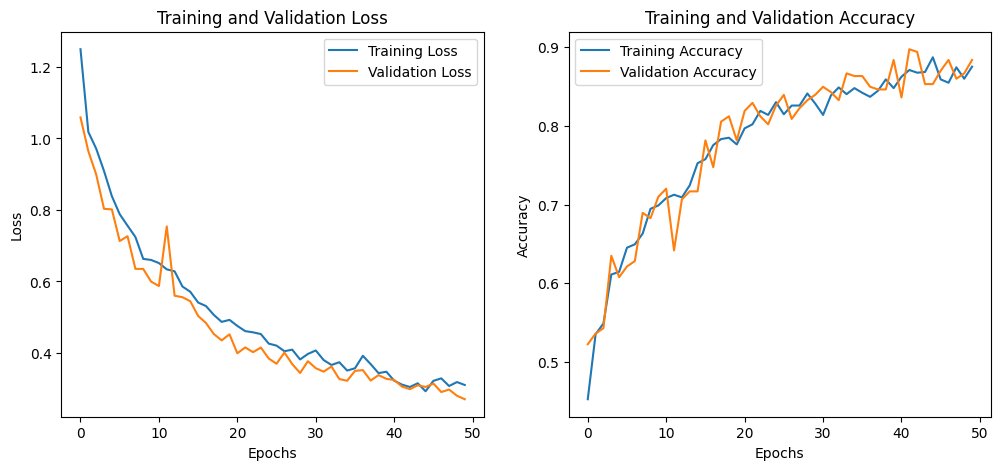

In [ ]:
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

input_size = X_train_tensor.shape[1]
output_size = len(y.unique())
learning_rate = 0.001
num_epochs = 50

# Initialize the model, loss function, and optimizer
model = MLP(input_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate training metrics
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    with torch.no_grad():
        outputs_val = model(X_test_tensor)
        val_loss = criterion(outputs_val, y_test_tensor)
        _, predicted_val = torch.max(outputs_val.data, 1)
        correct_val = (predicted_val == y_test_tensor).sum().item()
        val_accuracy = correct_val / y_test_tensor.size(0)

        val_losses.append(val_loss.item())
        val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, '
          f'Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {val_accuracy:.4f}')


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Epoch [1/50], Training Loss: 0.3034, Training Accuracy: 0.8703, Validation Loss: 0.2869, Validation Accuracy: 0.8840
Epoch [2/50], Training Loss: 0.2945, Training Accuracy: 0.8746, Validation Loss: 0.2880, Validation Accuracy: 0.8737
Early stopping counter: 1/10
Epoch [3/50], Training Loss: 0.2696, Training Accuracy: 0.8942, Validation Loss: 0.2714, Validation Accuracy: 0.8737
Epoch [4/50], Training Loss: 0.2657, Training Accuracy: 0.8874, Validation Loss: 0.2863, Validation Accuracy: 0.8976
Early stopping counter: 1/10
Epoch [5/50], Training Loss: 0.2741, Training Accuracy: 0.8865, Validation Loss: 0.2666, Validation Accuracy: 0.8840
Epoch [6/50], Training Loss: 0.2856, Training Accuracy: 0.8788, Validation Loss: 0.2641, Validation Accuracy: 0.8737
Epoch [7/50], Training Loss: 0.2766, Training Accuracy: 0.8840, Validation Loss: 0.3075, Validation Accuracy: 0.8498
Early stopping counter: 1/10
Epoch [8/50], Training Loss: 0.2958, Training Accuracy: 0.8857, Validation Loss: 0.2517, Valid

<ipython-input-34-32f1151039dc>:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


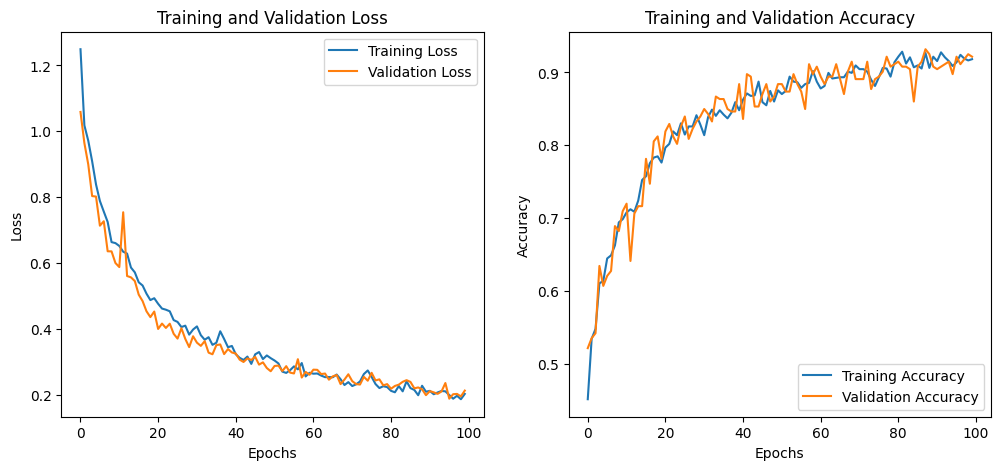

In [ ]:
patience = 10
min_delta = 0.001
best_val_loss = float('inf')
patience_counter = 0

# Training loop with early stopping
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate training metrics
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    with torch.no_grad():
        outputs_val = model(X_test_tensor)
        val_loss = criterion(outputs_val, y_test_tensor)
        _, predicted_val = torch.max(outputs_val.data, 1)
        correct_val = (predicted_val == y_test_tensor).sum().item()
        val_accuracy = correct_val / y_test_tensor.size(0)

        val_losses.append(val_loss.item())
        val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, '
          f'Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Early stopping check
    if val_loss.item() < best_val_loss - min_delta:
        best_val_loss = val_loss.item()
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        print(f"Early stopping counter: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("Early stopping triggered. Stopping training.")
            break

# Load the best model before final evaluation
model.load_state_dict(torch.load('best_model.pth'))

# Plotting results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()